# Logestic regression


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Loading


In [17]:
def load_data(file_path, batch_size=64):
    data = pd.read_csv(file_path)
    Y = data['label'].values
    X = data.drop(columns=['label'], axis=1).values
    X = X / 255.0  # Normalize features

    mask = (Y == 0) | (Y == 1)  # Binary classification mask
    X_binary = X[mask]
    Y_binary = Y[mask]

    # Split the data 60-20-20
    X_train_binary, X_temp_binary, Y_train_binary, Y_temp_binary = train_test_split(
        X_binary, Y_binary, test_size=0.4, stratify=Y_binary, random_state=30
    )
    X_val_binary, X_test_binary, Y_val_binary, Y_test_binary = train_test_split(
        X_temp_binary, Y_temp_binary, test_size=0.5, stratify=Y_temp_binary, random_state=30
    )

    train_dataset = TensorDataset(torch.tensor(X_train_binary, dtype=torch.float32),
                                  torch.tensor(Y_train_binary, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val_binary, dtype=torch.float32),
                                torch.tensor(Y_val_binary, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test_binary, dtype=torch.float32),
                                 torch.tensor(Y_test_binary, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Logestic Class

In [18]:
class LogisticRegressionScratch:
    def __init__(self, input_dim=784, lr=0.01):
        self.W = torch.zeros((input_dim, 1), dtype=torch.float32)
        self.b = torch.zeros(1, dtype=torch.float32)
        self.lr = lr

    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))

    def loss(self, y_pred, y_true):
        eps = 1e-9
        return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

    def gradient(self, X, y_pred, y_true):
        m = X.shape[0]
        dw = torch.matmul(X.T, (y_pred - y_true)) / m
        db = torch.sum(y_pred - y_true) / m
        return dw, db

    def update_weights(self, dw, db):
        self.W -= self.lr * dw
        self.b -= self.lr * db

    def accuracy(self, y_pred, y_true):
        preds = (y_pred >= 0.5).float()
        return (preds == y_true).float().mean()
     
    def plot_curves(self, train_losses, val_losses, train_accs, val_accs):
        plt.figure(figsize=(12, 5))
        plt.suptitle("Training Progress of Logistic Regression", fontsize=14)
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Val Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Curves')

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy', color='blue')
        plt.plot(val_accs, label='Val Accuracy', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Curves')
        plt.show()

    def train(self, train_loader, val_loader, epochs=15, patience=3):
        train_losses, val_losses, train_accs, val_accs = [], [], [], []
        best_val_loss, patience_counter = float('inf'), 0
        best_weights = (self.W.clone(), self.b.clone())
    

        for epoch in range(epochs):
            # === TRAIN ===
            epoch_train_loss, correct, total = 0, 0, 0
            for X_batch, y_batch in train_loader:
                y_batch = y_batch.view(-1, 1).float()
                y_pred = self.sigmoid(X_batch @ self.W + self.b)
                loss = self.loss(y_pred, y_batch)
                epoch_train_loss += loss.item()

                dw, db = self.gradient(X_batch, y_pred, y_batch)
                self.update_weights(dw, db)

                correct += ((y_pred >= 0.5).float() == y_batch).float().sum().item()
                total += y_batch.size(0)

            train_losses.append(epoch_train_loss / len(train_loader))
            train_accs.append(correct / total)

            # === VALIDATION ===
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_batch = y_batch.view(-1, 1).float()
                    y_pred = self.sigmoid(X_batch @ self.W + self.b)
                    loss = self.loss(y_pred, y_batch)
                    val_loss += loss.item()
                    correct += ((y_pred >= 0.5).float() == y_batch).float().sum().item()
                    total += y_batch.size(0)

            val_losses.append(val_loss / len(val_loader))
            val_accs.append(correct / total)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.5f} | Val Loss: {val_losses[-1]:.5f}")

            if val_losses[-1] + 1e-10 < best_val_loss:
                best_val_loss = val_losses[-1]
                best_weights = (self.W.clone(), self.b.clone())
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        self.W, self.b = best_weights
        
        
        return train_losses, val_losses, train_accs, val_accs

    def test(self, test_loader):
        total_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_batch = y_batch.view(-1, 1).float()
                y_pred = self.sigmoid(X_batch @ self.W + self.b)
                loss = self.loss(y_pred, y_batch)
                total_loss += loss.item()
                preds = (y_pred >= 0.5).float()
                correct += (preds == y_batch).float().sum().item()
                total += y_batch.size(0)
                all_preds.extend(preds.numpy())
                all_labels.extend(y_batch.numpy())

        cm = confusion_matrix(all_labels, all_preds)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
        plt.show()
        print(f"Test Accuracy: {correct/total*100:.2f}%")
        return correct / total, cm


# Train the model

Epoch 1/15 | Train Loss: 0.05185 | Val Loss: 0.01745
Epoch 2/15 | Train Loss: 0.01468 | Val Loss: 0.01195
Epoch 3/15 | Train Loss: 0.01095 | Val Loss: 0.00983
Epoch 4/15 | Train Loss: 0.00921 | Val Loss: 0.00871
Epoch 5/15 | Train Loss: 0.00813 | Val Loss: 0.00795
Epoch 6/15 | Train Loss: 0.00740 | Val Loss: 0.00743
Epoch 7/15 | Train Loss: 0.00684 | Val Loss: 0.00707
Epoch 8/15 | Train Loss: 0.00644 | Val Loss: 0.00675
Epoch 9/15 | Train Loss: 0.00610 | Val Loss: 0.00647
Epoch 10/15 | Train Loss: 0.00582 | Val Loss: 0.00626
Epoch 11/15 | Train Loss: 0.00560 | Val Loss: 0.00608
Epoch 12/15 | Train Loss: 0.00539 | Val Loss: 0.00593
Epoch 13/15 | Train Loss: 0.00524 | Val Loss: 0.00579
Epoch 14/15 | Train Loss: 0.00507 | Val Loss: 0.00568
Epoch 15/15 | Train Loss: 0.00491 | Val Loss: 0.00558


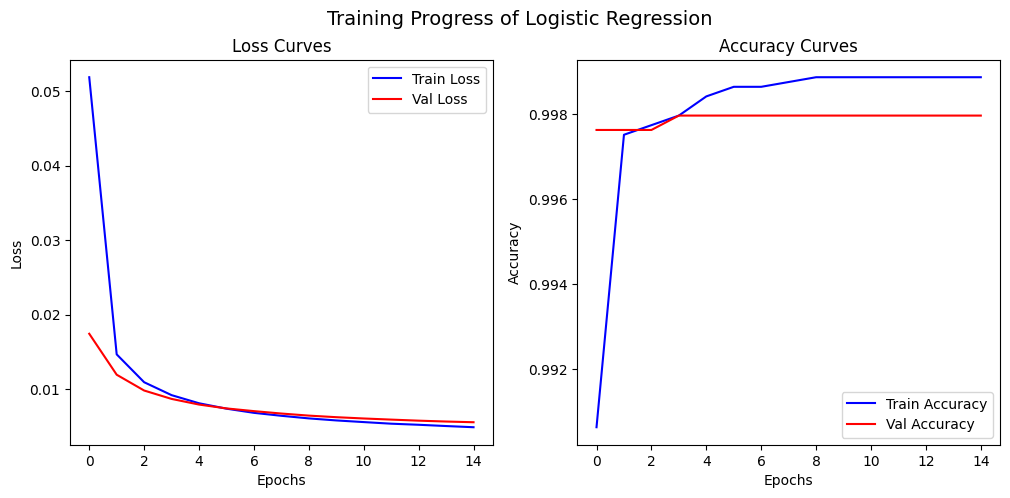

In [19]:
train_loader, val_loader, test_loader = load_data("mnist_All.csv")

# After analysis, you can test one final model
model = LogisticRegressionScratch(784, lr=0.1)
train_losses, val_losses, train_accs, val_accs = model.train(train_loader, val_loader)
model.plot_curves(train_losses, val_losses, train_accs, val_accs)


## Metrics


In [20]:
def convergence_speed(val_losses):
    best = val_losses[0]
    for i, v in enumerate(val_losses[1:], 1):
        if abs(v - best) / best < 0.001:
            return i
        best = min(best, v)
    return len(val_losses)

def stability_measure(val_losses):
    tail = val_losses[-5:] if len(val_losses) >= 5 else val_losses
    return np.std(tail)

def gradient_noise_measure(train_losses):
    return np.var(np.diff(train_losses))


Test Data

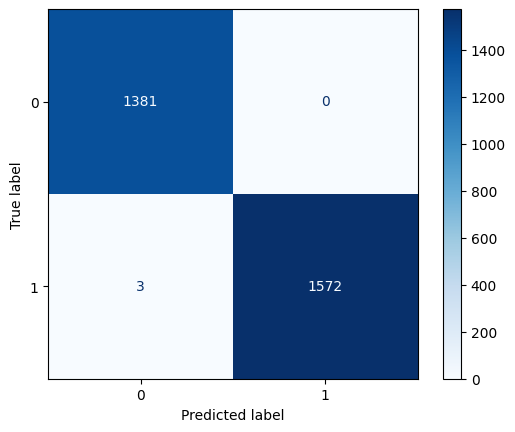

Test Accuracy: 99.90%


(0.9989851150202977,
 array([[1381,    0],
        [   3, 1572]]))

In [21]:
model.test(test_loader)

# Learning Rate and Batch analysis

In [22]:
def run_analysis(file_path):
    lr_values = [0.001, 0.01, 0.1, 1.0]
    batch_sizes = [16, 32, 64, 128]
    lr_results, bs_results = [], []

    train_loader, val_loader, _ = load_data(file_path, batch_size=64)

    # === LEARNING RATE ANALYSIS ===
    val_losses = []
    for lr in lr_values:
        model = LogisticRegressionScratch(784, lr)
        train_loss, val_loss, _, _ = model.train(train_loader, val_loader)
        lr_results.append((lr, val_loss[-1], convergence_speed(val_loss), stability_measure(val_loss)))
        val_losses.append(val_loss)

    plt.figure(figsize=(8, 5))
    for i, lr in enumerate(lr_values):
        plt.plot(val_losses[i], label=f"LR={lr}")
    plt.title("Learning Rate Effect on Validation Loss")
    plt.xlabel("Epochs"); plt.ylabel("Validation Loss"); plt.legend(); plt.grid(True)
    plt.show()

    print("\n=== Learning Rate Results ===")
    print("LR\tFinalLoss\tConvergeEpoch\tStability")
    for lr, loss, conv, stab in lr_results:
        print(f"{lr}\t{loss:.5f}\t{conv}\t\t{stab:.6f}")

    # === BATCH SIZE ANALYSIS ===
    val_losses = []
    for bs in batch_sizes:
        train_loader, val_loader, _ = load_data(file_path, batch_size=bs)
        model = LogisticRegressionScratch(784, 0.1)
        train_loss, val_loss, _, _ = model.train(train_loader, val_loader)
        bs_results.append((bs, val_loss[-1], gradient_noise_measure(train_loss)))
        val_losses.append(val_loss)

    plt.figure(figsize=(8, 5))
    for i, bs in enumerate(batch_sizes):
        plt.plot(val_losses[i], label=f"Batch={bs}")
    plt.title("Batch Size Effect on Validation Loss")
    plt.xlabel("Epochs"); plt.ylabel("Validation Loss"); plt.legend(); plt.grid(True)
    plt.show()

    print("\n=== Batch Size Results ===")
    print("BatchSize\tFinalLoss\tGradientNoise")
    for bs, loss, noise in bs_results:
        print(f"{bs}\t\t{loss:.5f}\t\t{noise:.6f}")


Epoch 1/15 | Train Loss: 0.53338 | Val Loss: 0.41495
Epoch 2/15 | Train Loss: 0.34996 | Val Loss: 0.29336
Epoch 3/15 | Train Loss: 0.25950 | Val Loss: 0.22641
Epoch 4/15 | Train Loss: 0.20659 | Val Loss: 0.18478
Epoch 5/15 | Train Loss: 0.17221 | Val Loss: 0.15655
Epoch 6/15 | Train Loss: 0.14828 | Val Loss: 0.13622
Epoch 7/15 | Train Loss: 0.13054 | Val Loss: 0.12091
Epoch 8/15 | Train Loss: 0.11701 | Val Loss: 0.10895
Epoch 9/15 | Train Loss: 0.10617 | Val Loss: 0.09937
Epoch 10/15 | Train Loss: 0.09744 | Val Loss: 0.09150
Epoch 11/15 | Train Loss: 0.09022 | Val Loss: 0.08492
Epoch 12/15 | Train Loss: 0.08408 | Val Loss: 0.07933
Epoch 13/15 | Train Loss: 0.07885 | Val Loss: 0.07454
Epoch 14/15 | Train Loss: 0.07447 | Val Loss: 0.07036
Epoch 15/15 | Train Loss: 0.07050 | Val Loss: 0.06670
Epoch 1/15 | Train Loss: 0.21312 | Val Loss: 0.09116
Epoch 2/15 | Train Loss: 0.07042 | Val Loss: 0.05337
Epoch 3/15 | Train Loss: 0.04724 | Val Loss: 0.03948
Epoch 4/15 | Train Loss: 0.03691 | Val L

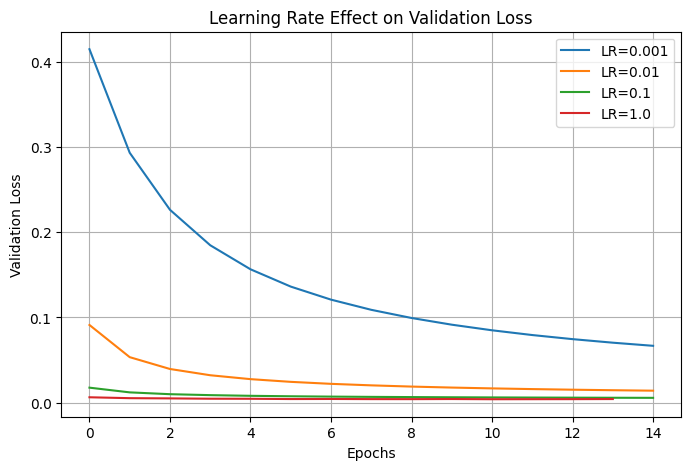


=== Learning Rate Results ===
LR	FinalLoss	ConvergeEpoch	Stability
0.001	0.06670	15		0.006444
0.01	0.01401	15		0.000950
0.1	0.00560	15		0.000177
1.0	0.00419	14		0.000090
Epoch 1/15 | Train Loss: 0.02194 | Val Loss: 0.00878
Epoch 2/15 | Train Loss: 0.00742 | Val Loss: 0.00678
Epoch 3/15 | Train Loss: 0.00588 | Val Loss: 0.00600
Epoch 4/15 | Train Loss: 0.00516 | Val Loss: 0.00559
Epoch 5/15 | Train Loss: 0.00469 | Val Loss: 0.00531
Epoch 6/15 | Train Loss: 0.00436 | Val Loss: 0.00506
Epoch 7/15 | Train Loss: 0.00408 | Val Loss: 0.00488
Epoch 8/15 | Train Loss: 0.00385 | Val Loss: 0.00476
Epoch 9/15 | Train Loss: 0.00366 | Val Loss: 0.00463
Epoch 10/15 | Train Loss: 0.00349 | Val Loss: 0.00454
Epoch 11/15 | Train Loss: 0.00335 | Val Loss: 0.00448
Epoch 12/15 | Train Loss: 0.00323 | Val Loss: 0.00441
Epoch 13/15 | Train Loss: 0.00309 | Val Loss: 0.00436
Epoch 14/15 | Train Loss: 0.00305 | Val Loss: 0.00435
Epoch 15/15 | Train Loss: 0.00291 | Val Loss: 0.00428
Epoch 1/15 | Train Loss: 0.0

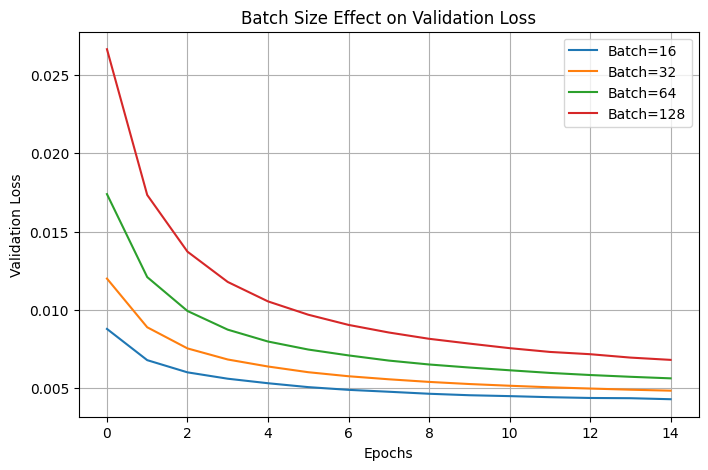


=== Batch Size Results ===
BatchSize	FinalLoss	GradientNoise
16		0.00428		0.000013
32		0.00483		0.000034
64		0.00562		0.000087
128		0.00680		0.000217


In [23]:
run_analysis("mnist_All.csv")